In [1]:
from sklearn.manifold import TSNE

In [2]:
import os
from matplotlib import pyplot as plt
os.sys.path.append('./..')
import pandas as pd
from utils.loadgenius import DataLoader

# Pointing the loader to the data loading instruction
dl = DataLoader('./../catalog.yml')

main = dl.load('main_cleaned')
ports = dl.load('ports_cleaned')
importers = dl.load('importers_cleaned')

# goals

- Identify patterns that may correlate with the hierarchy in ranking
- Create a model that predict importer categorized class:\

    Assume that Blume is sensitive to risks, the metrics to be optimized for such a model should be **precision** for high class. \
    In other words, everytime we predict that an importer belongs to a high class, we want to be as certain as we can.
    We place less importance on **recall** mistakes (made when we mis-classified a high-class as lower)
    

# Importer class

Based on the distribution of ranks, I decide to:

- Consider all ranks above 5000 as lowest class
- Next lowest class is 2000~5000
- Best class is top 500

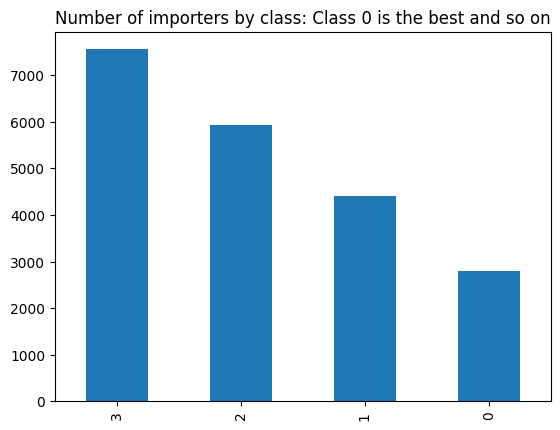

In [3]:
importers['importer_rank_cate'] = importers['importer_rank'].apply(lambda x : 0 if x < 500
                                                                   else (1 if x < 2000 
                                                                         else (2 if x < 5000 else 3)
                                                                        )
                                                                  )

importers['importer_rank_cate'].value_counts().plot.bar();
plt.title("Number of importers by class: Class 0 is the best and so on");

In [4]:
main = main.merge(importers[['id', 'importer_rank_cate']])

# importer attributes

`n_states`: The number of unique states associated with each importer ID (in consignee string).

`n_zipcodes`: The number of unique zipcodes associated with each importer ID (in consignee string).

`n_months`: The number of unique filing months for each importer ID.

`n_origins`: The number of unique countries of origin for each importer ID.

`total_teu`: The sum of calculated TEU (twenty-foot equivalent units) across all records for each importer ID.

`avg_teu`: The average of calculated TEU (twenty-foot equivalent units) across all records for each importer ID.

`n_goods`: The number of unique HS codes (Harmonized System codes) across all records for each importer ID.

`n_ports`: The number of unique ports of unlading across all records for each importer ID.

`n_states`: The number of unique states of unlading across all records for each importer ID.

`major_origin`: The country of origin that appears most frequently for each importer ID.

`major_goods`: The HS code that appears most frequently for each importer ID.

`major_port_state`: The state of unlading that appears most frequently for each importer ID.

`biggest_gap`: The maximum time gap between consecutive filing months for each importer ID.

`smallest_gap`: The minimum time gap between consecutive filing months for each importer ID.

`mean_gap`: The mean time gap between consecutive filing months for each importer ID.

In [5]:
# inner join is ok here because we made sure now rows will be dropped in the cleaning step
main = main.merge(ports, left_on="port_of_unlading", right_on="port_code", how="inner")

In [15]:
# Calculating attributes

importer_profile = (
    main
    .sort_values(['id', 'file_month'])
    .groupby('id')
    .agg(
        n_zipcodes=('zip_code', 'nunique'),
        n_istates=('state_name', 'nunique'),
        importer_rank_cate=('importer_rank_cate', 'first'),
        importer_rank=('importer_rank', 'min'),
        n_months=('file_month', 'nunique'),
        n_origins=('country_of_origin', 'nunique'),
        total_teu=('calculated_teu', 'sum'),
        avg_teu=('calculated_teu', 'mean'),
        n_goods=('hs_codes_shorten', 'nunique'),
        n_ports=('port_of_unlading', 'nunique'),
        n_states=('port_state', 'nunique'),
        major_origin=('country_of_origin', lambda x: x.value_counts().idxmax()),
        major_goods=('hs_codes_shorten', lambda x: x.value_counts().idxmax()),
        major_port_state=('port_state', lambda x: x.value_counts().idxmax()),
        biggest_gap=('file_month', lambda x: x.drop_duplicates().diff().max()),
        smallest_gap=('file_month', lambda x: x.drop_duplicates().diff().min()),
    )
)

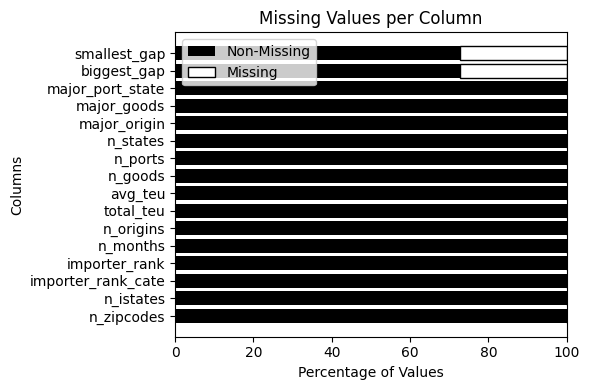

In [16]:
from utils.pretty import pprint, plot_missing_values, plot_value_counts

plot_missing_values(importer_profile,
                    as_percentage=True,
                    figsize=(6,4)
                   )

It shows that we have missing values for gap attributes caused by no gaps exist at all (companies that only import in ONE month), which is a curious case. Upon examination of these cases (active in only one month), **I don't find any patterns that correlate with ranking**. For instance:

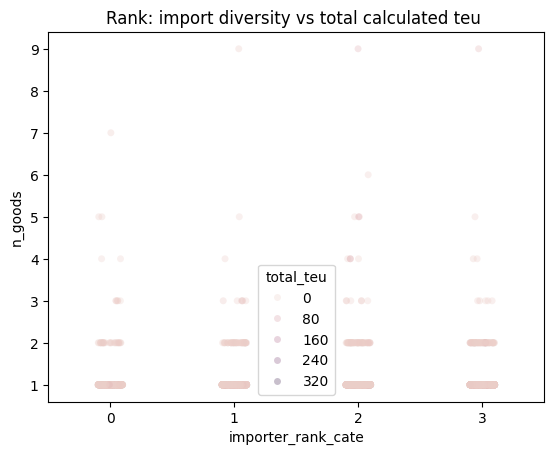

In [17]:
import seaborn as sns

sns.stripplot(data=importer_profile[importer_profile['biggest_gap'].isna()],
               x="importer_rank_cate", y="n_goods", hue='total_teu', alpha=.3);
plt.title("Rank: import diversity vs total calculated teu ");

This leads to 2 probabilities :
- the dependencies can be in a higher dimensional space (something that correlation plots cannot pick up but tree models might)
- categorical values might be also important indicators of rank.

Before moving on, I will fill the nans with 12 (the number of months). This is to assume that the importer only purchase one per year (which is reasonable given the data)

In [18]:
gap_cols = ['smallest_gap', 'biggest_gap']
for col in gap_cols:
    importer_profile[col] = importer_profile[col].fillna(12)

# tsne

As mentioned above, we wan to know if numerical dependency happens in higher dimensions

To confirm that, we use TSNE to reduce the data to 2 dimensions and check for clustering. TSNE is known for the ability to make datapoints closer, which align with our goal: to identify the cluster of high-class importers

In [24]:
numericals = ["n_months", "n_origins", "total_teu",
             "avg_teu", "n_goods", "n_ports", "n_states",
             "biggest_gap", "smallest_gap", "n_zipcodes", "n_istates"]

categoricals = ["major_origin", "major_goods", "major_port_state"]

target = ['importer_rank_cate']

In [30]:
df_processed.head(10)

,n_months,n_origins,total_teu,avg_teu,n_goods,n_ports,n_states,biggest_gap,smallest_gap,n_zipcodes,...,major_port_state_ Newark,major_port_state_ North Carolina,major_port_state_ Oregon,major_port_state_ Pennsylvania,major_port_state_ Puerto Rico,major_port_state_ Rhode Island,major_port_state_ South Carolina,major_port_state_ Texas,major_port_state_ Virginia,major_port_state_ Washington
id,,,,,,,,,,,,,,,,,,,,,
00009c9ff6653793dec61518eca46045,3,1,5.000000,1.000000,2,2,2,2.0,1.0,1,...,1,0,0,0,0,0,0,0,0,0
0000a4d5018dad1e8f06ca7f98c8a9ad,3,2,0.517556,0.172519,2,2,2,7.0,3.0,2,...,1,0,0,0,0,0,0,0,0,0
0001d2a16db43a11b3015820be8c327c,9,4,21.022987,1.106473,5,4,3,2.0,1.0,6,...,0,0,0,0,0,0,0,0,0,0
0007cd5fd3b436b2abaf1c17630fc738,1,2,5.000000,1.666667,3,1,1,12.0,12.0,1,...,0,0,0,0,0,0,0,0,0,0
000da006a9ad07bb137b782587310f39,2,1,5.000000,1.666667,1,2,2,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0
000db649efa805478a535b9e45dea04d,2,2,1.281614,0.640807,2,1,1,6.0,6.0,1,...,0,0,0,0,1,0,0,0,0,0
0011a1241a445b5769c257173ba753ae,7,2,319.500000,6.656250,2,6,4,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0
0012c44103949033c69929e071b7877d,7,1,50.000000,2.941176,6,3,2,2.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0
0019cae23f099803e170c12ac7643749,5,4,29.931005,1.995400,8,3,2,3.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0


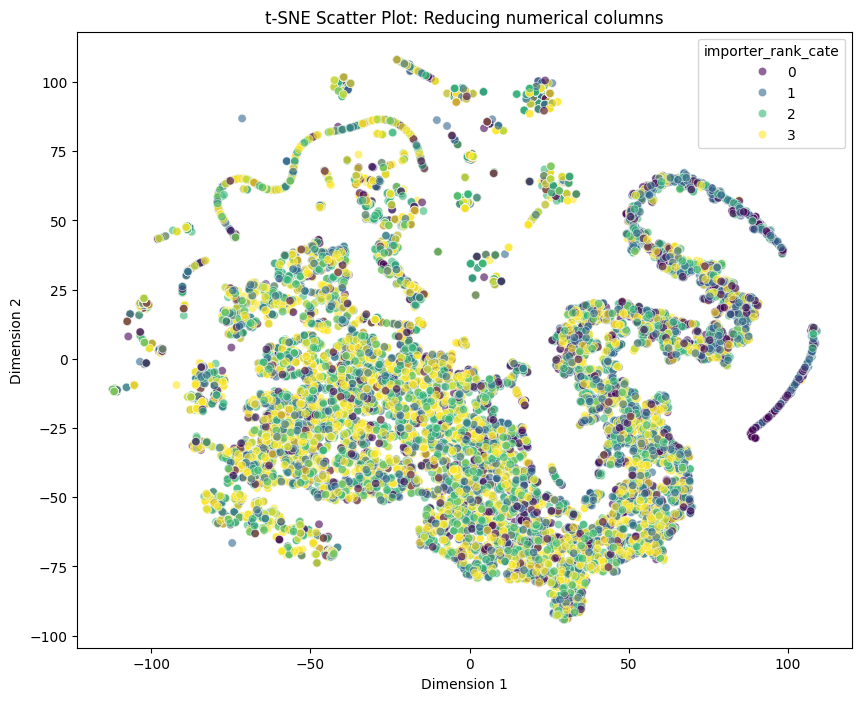

In [28]:
# Get dummies for categorical columns
df_dummies = pd.get_dummies(importer_profile[categoricals])

# Concatenate the numeric columns and dummy variables
df_processed = pd.concat([importer_profile[numericals], df_dummies], axis=1)


tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(df_processed[numericals])

# Create a DataFrame with the reduced dimensions
df_tsne = pd.DataFrame(tsne_result, columns=['Dimension 1', 'Dimension 2'])

# Add the 'importer_rank_cate' column to the reduced DataFrame
df_tsne['importer_rank_cate'] = list(importer_profile['importer_rank_cate'])

# Step 3: Scatter plot using the reduced dimensions
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2',
                hue='importer_rank_cate',
                data=df_tsne,
                palette='viridis',
               alpha=.6)
plt.title("t-SNE Scatter Plot: Numerical columns only")
plt.show()


We can see from the plot above that there is actually a tiny cluster that looks like a separated tail on the right of the graph where high-class importers locate. 

We can also identify another tail on the upper side of the tail mentioned above.

The clustering is not as clear for other charted areas, where both high and low classes mingle.

Having said that, this is still a significant finding. It suggests that we can train a model to just look at certain section of the data and assign a high class, achieving high precision. From the investment perspective, these are the low risk zone.

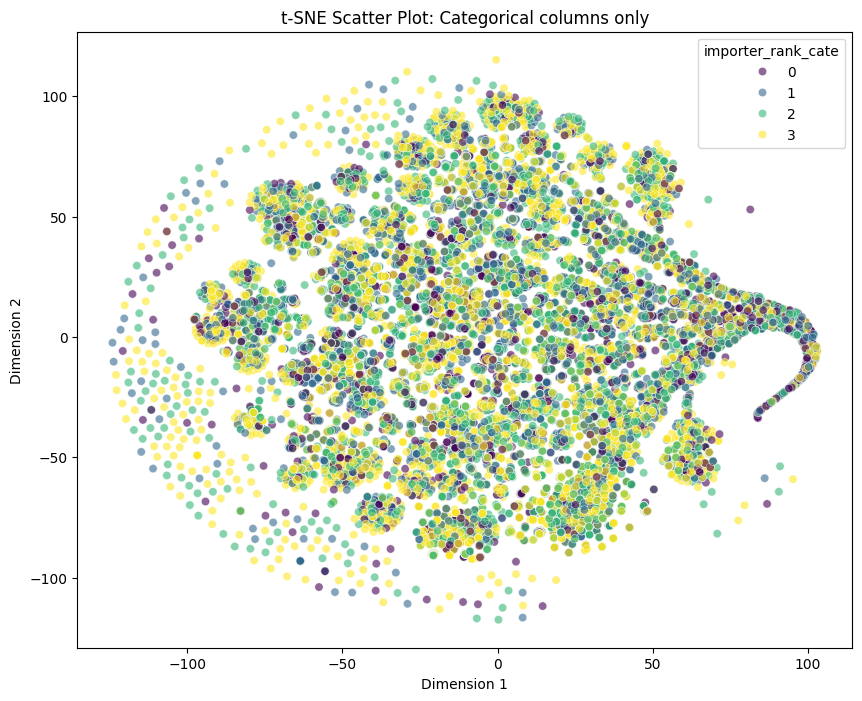

In [38]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50.0,)
tsne_result = tsne.fit_transform(df_processed[['n_goods'] +
                                              [i for i in df_processed.columns if i not in numericals]])

# Create a DataFrame with the reduced dimensions
df_tsne = pd.DataFrame(tsne_result, columns=['Dimension 1', 'Dimension 2'])

# Add the 'importer_rank_cate' column to the reduced DataFrame
df_tsne['importer_rank_cate'] = list(importer_profile['importer_rank_cate'])

# Step 3: Scatter plot using the reduced dimensions
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2',
                hue='importer_rank_cate',
                data=df_tsne,
                palette='viridis',
               alpha=.6)
plt.title("t-SNE Scatter Plot: Categorical columns only")
plt.show()
